In [18]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from IPython.display import display, HTML
show_html=lambda html: display(HTML(html))

In [19]:
!pip install scikit_optimize
from skopt import BayesSearchCV

In [20]:
#Ntebook 1 starts from here

In [21]:
df=pd.read_csv('Energy.csv',index_col=0)
pd.set_option('display.max_columns',50)
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [22]:
df.shape

(19735, 29)

In [23]:
df.describe(include='all')

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
unique,19735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,11-01-2016 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.412580,755.522602,79.750418,4.039752,38.330834,3.760995,24.988033,24.988033
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.318464,7.399441,14.901088,2.451221,11.794719,4.195248,14.496634,14.496634
min,NaN,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,NaN,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.670000,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,NaN,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.920000,756.100000,83.666667,3.666667,40.000000,3.430000,24.897653,24.897653
75%,NaN,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.400000,760.933333,91.666667,5.500000,40.000000,6.570000,37.583769,37.583769


In [24]:
energy=df.loc[:,'Appliances']
energy.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

In [25]:
e_train, e_test=energy.iloc[:12000], energy.iloc[12000:]
e_train.shape, e_test.shape

((12000,), (7735,))

In [26]:
##We have as of now loaded the dataset, seen it, and made a new varaibe that holds all the value of the column 'Appliances', End of notebook1

In [27]:
##Notebook#2: we're working with the window, the size of the window(1D array) will be w+1
#why w+1? so that we have the window before data to be predicted in the first w positions and the data to be predicted in the last ones
w=4
#THe function that generates the window will return a 3D matrix where one of the dimensions is a single column, we use squeeze function to eliminate the redundant column
#then we'll generate data matrix for test and train
#then we'll normalize the data




In [28]:
#lets normalize the data
scaler=MinMaxScaler()


e_train_s = scaler.fit_transform(e_train.to_numpy().reshape(-1,1))
e_test_s = scaler.transform(e_test.to_numpy().reshape(-1,1))

# Defining Windows
# X : information we use to make the predictions
# y : real energy consumption values that we want to achieve with the predictions
windows_train = sliding_window_view(e_train_s,w+1,axis=0).copy()
X_train_w, y_train_w = windows_train.squeeze()[:,:-1], windows_train.squeeze()[:,-1]

windows_test = sliding_window_view(e_test_s,w+1,axis=0).copy()
X_test_w, y_test_w = windows_test.squeeze()[:,:-1], windows_test.squeeze()[:,-1]




In [29]:
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape

((11996, 4), (7731, 4), (11996,), (7731,))

In [30]:
#NOtebook2 ends here
#og e_train and e_test were row vectors, if you orint e_train.to_numpy() you'll get a row vector [...] so you reshape with -1,1 to get a column vector. to turn a column vector to row you reshape with 1,-1
#X variables have 4 columns that will be used to rpedict the y's 1 column
#whhat does the 11996 mean? remeber we picked 12000 samples to belong to the testing,training split?
#training took 11k and the rest were with the testing split

Actually begining the support vector machine:

In [31]:
param={'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.1,11)} #define the values of C and epsilon to go into the svm function

lsvr=SVR(kernel='linear',max_iter=25000, cache_size=2000)

lsvr_search=BayesSearchCV(lsvr, param, n_iter=15, cv=TimeSeriesSplit(n_splits=5, gap=w+1),
                          scoring=make_scorer(mean_squared_error, greater_is_better=False),
                          n_jobs=-1, refit=True, random_state=0
                          )
lsvr_search.fit(X_train_w, y_train_w)

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, kernel='linear', max_iter=25000),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1....
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])})

In [35]:
show_html(pd.DataFrame(lsvr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())
#head(15) gives top 15 values

,params,mean_test_score,rank_test_score
10,"{'C': 0.1445439770745928, 'epsilon': 0.02}",-0.003871,1
11,"{'C': 0.25118864315095796, 'epsilon': 0.02}",-0.003878,2
4,"{'C': 0.023988329190194897, 'epsilon': 0.02}",-0.003931,3
13,"{'C': 0.38018939632056126, 'epsilon': 0.0}",-0.003957,4
2,"{'C': 1.513561248436207, 'epsilon': 0.0}",-0.003962,5


In [36]:
len(lsvr_search.cv_results_)

15

Performance evaluation:

In [37]:
mean_squared_error(y_test_w, lsvr_search.predict(X_test_w)), mean_absolute_error(y_test_w, lsvr_search.predict(X_test_w))

(0.0036425065580647387, 0.024667876915467978)

Let's visiualize

In [39]:
import matplotlib.pyplot as plt

In [40]:
len(y_test_w)  #too many so we pick only less

7731

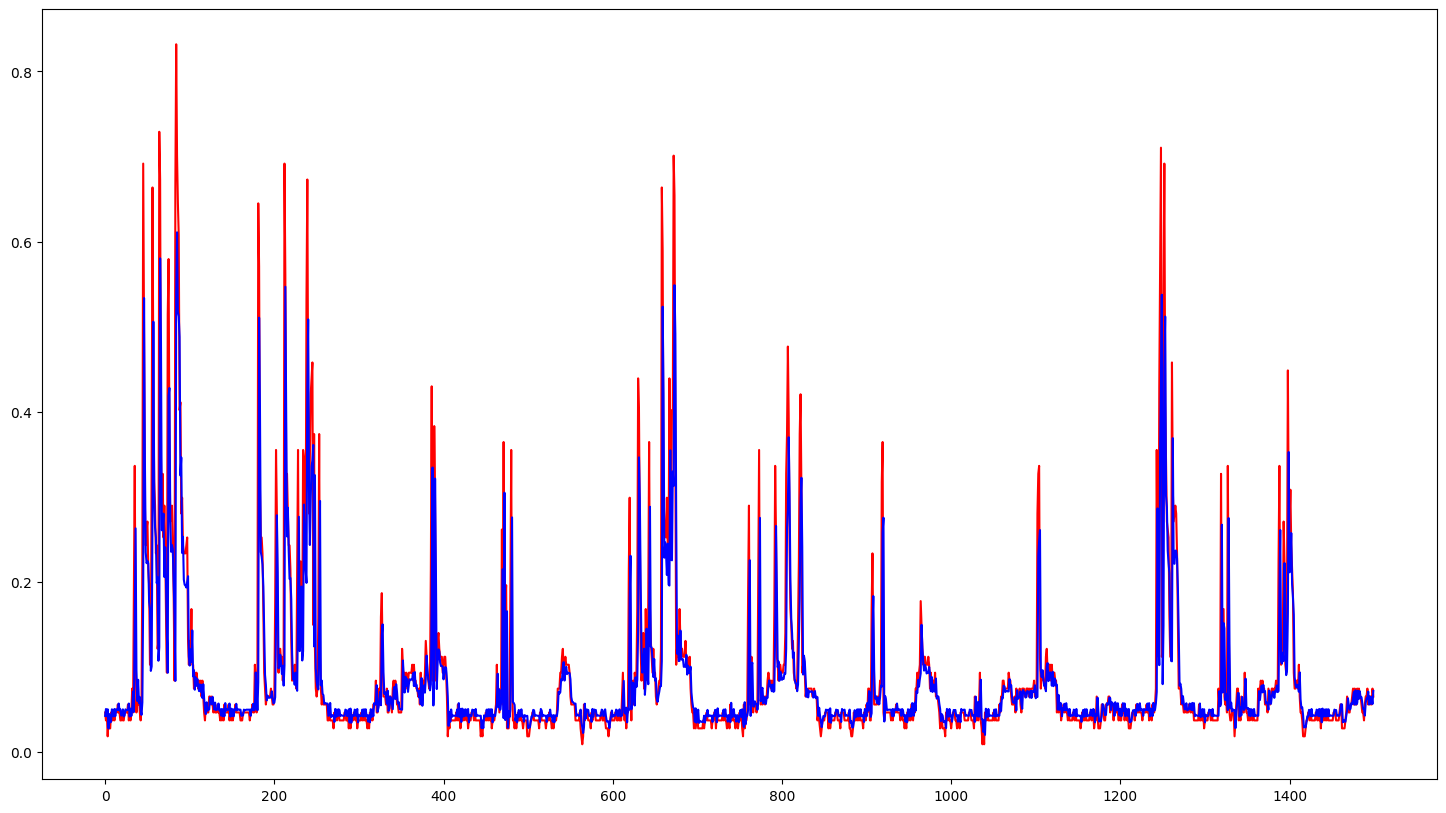

In [43]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:1500],'r')
plt.plot(lsvr_search.predict(X_test_w[:1500,:]),'b')

##NOtebook 4: Plynomial kernel

In [45]:
#For linear kernel we had to optimize two variables, epsilon and C
#For polynomial kernel, we have to optimize degree, C and epsilon
param={'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.1,11), 'degree':[2,3,4]} #define the values of C and epsilon to go into the svm function

psvr=SVR(kernel='poly',max_iter=25000, cache_size=2000)

psvr_search=BayesSearchCV(psvr, param, n_iter=15, cv=TimeSeriesSplit(n_splits=5, gap=w+1),
                          scoring=make_scorer(mean_squared_error, greater_is_better=False),
                          n_jobs=-1, refit=True, random_state=0
                          )
psvr_search.fit(X_train_w, y_train_w)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, kernel='poly', max_iter=25000),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99...
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'degree': [2, 3, 4],
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])})

In [47]:
show_html(pd.DataFrame(psvr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())


,params,mean_test_score,rank_test_score
14,"{'C': 0.023988329190194897, 'degree': 2, 'epsilon': 0.03}",-0.004744,1
10,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.03}",-0.004749,2
13,"{'C': 0.16595869074375597, 'degree': 2, 'epsilon': 0.03}",-0.005545,3
4,"{'C': 0.023988329190194897, 'degree': 2, 'epsilon': 0.08}",-0.005949,4
2,"{'C': 1.513561248436207, 'degree': 2, 'epsilon': 0.03}",-0.005996,5


In [48]:
len(psvr_search.cv_results_)

16

In [49]:
mean_squared_error(y_test_w, psvr_search.predict(X_test_w)), mean_absolute_error(y_test_w, psvr_search.predict(X_test_w))

(0.00431958170671823, 0.031918306610865935)

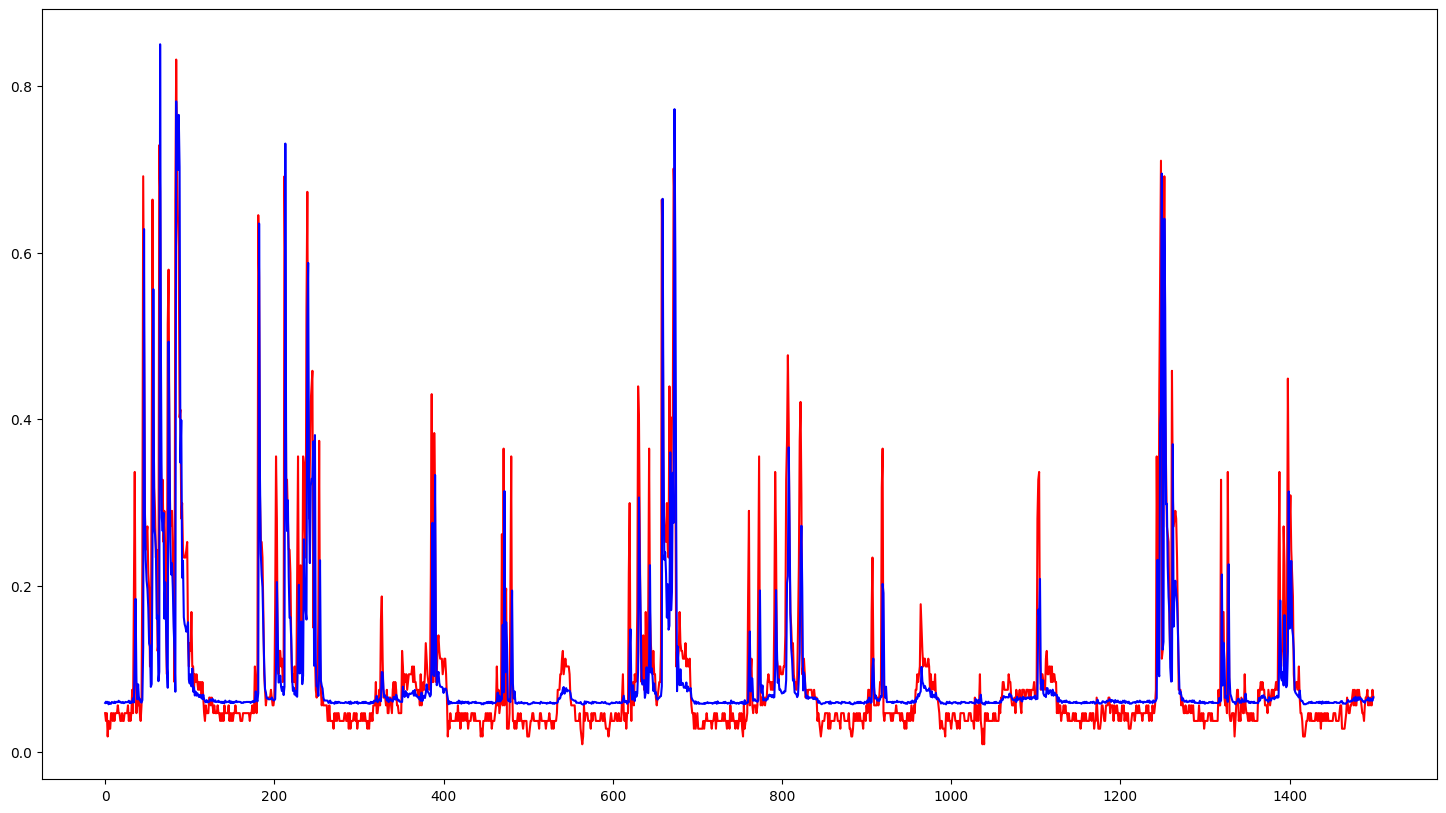

In [50]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:1500],'r')
plt.plot(psvr_search.predict(X_test_w[:1500,:]),'b')

##RBF Kernel
Notebook#5


In [51]:
#Now we have to agin optimize three functions, they are C, epsilon and gamma function (kernel coefficent)
param={'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.1,11), 'gamma':['scale','auto']} #define the values of C and epsilon to go into the svm function

rbf_svr=SVR(kernel='rbf',max_iter=25000, cache_size=2000)

rbf_svr_search=BayesSearchCV(rbf_svr, param, n_iter=15, cv=TimeSeriesSplit(n_splits=5, gap=w+1),
                          scoring=make_scorer(mean_squared_error, greater_is_better=False),
                          n_jobs=-1, refit=True, random_state=0
                          )
rbf_svr_search.fit(X_train_w, y_train_w)

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, max_iter=25000), n_iter=15,
              n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.2...
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                             'gamma': ['scale', 'auto']})

In [52]:
show_html(pd.DataFrame(rbf_svr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())


,params,mean_test_score,rank_test_score
10,"{'C': 0.1445439770745928, 'epsilon': 0.01, 'gamma': 'scale'}",-0.003696,1
9,"{'C': 0.16595869074375597, 'epsilon': 0.04, 'gamma': 'scale'}",-0.003746,2
14,"{'C': 0.3311311214825911, 'epsilon': 0.04, 'gamma': 'scale'}",-0.003783,3
11,"{'C': 0.009120108393559097, 'epsilon': 0.03, 'gamma': 'scale'}",-0.003881,4
13,"{'C': 0.006918309709189363, 'epsilon': 0.01, 'gamma': 'scale'}",-0.003958,5


In [53]:
mean_squared_error(y_test_w, rbf_svr_search.predict(X_test_w)), mean_absolute_error(y_test_w, rbf_svr_search.predict(X_test_w))

(0.0034824412607610392, 0.022975710391266904)

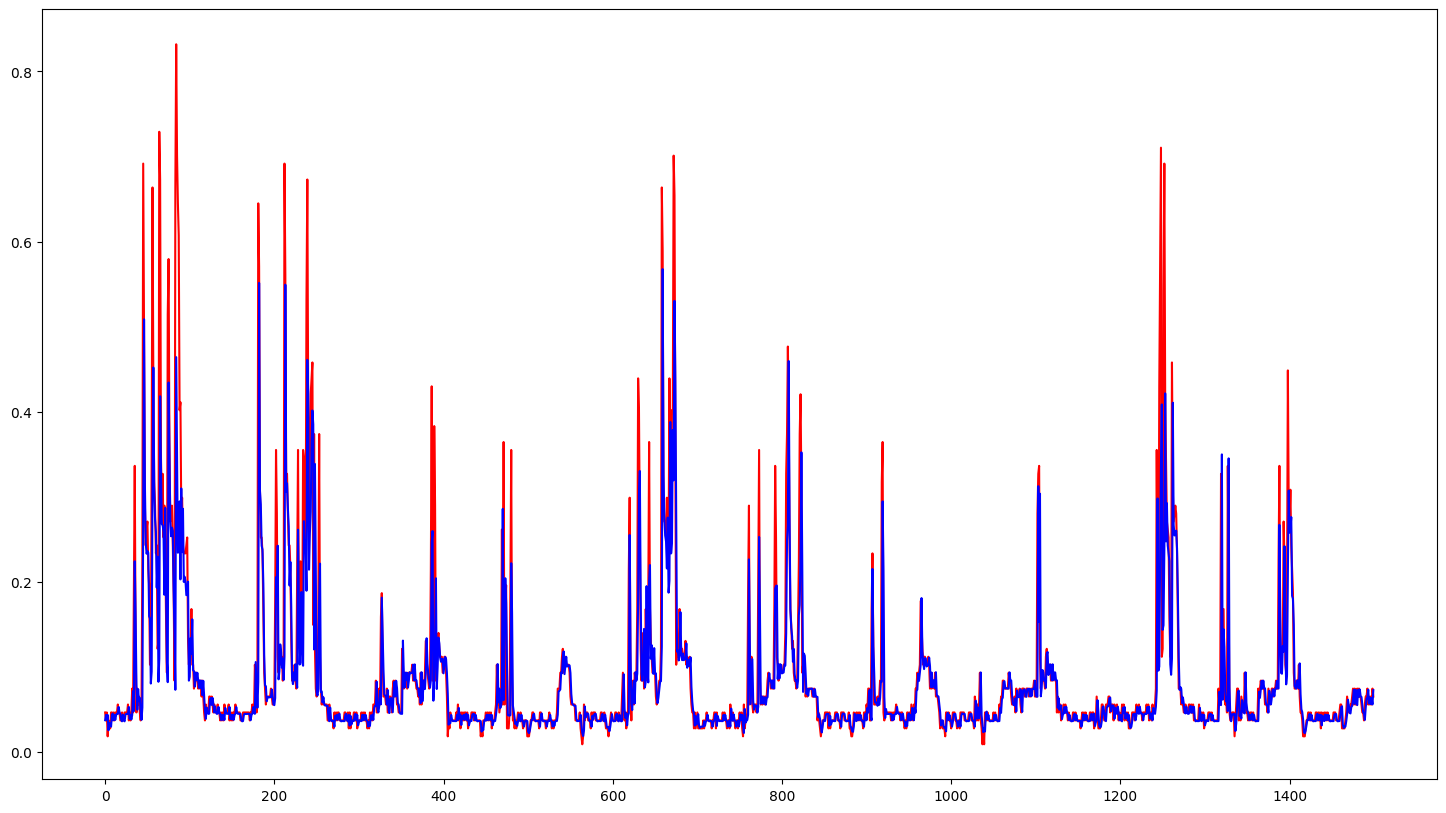

In [54]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:1500],'r')
plt.plot(rbf_svr_search.predict(X_test_w[:1500,:]),'b')